In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import numpy as np
from scipy.stats import norm

/Users/letitiaho/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('exemplar-formants.csv')
english_vowels = df[df.language == 'english']
arabic_vowels = df[df.language == 'arabic']
arabic_vowels.head(3)

,subject,language,trial,word,attempt,file,path,duration_s,t_center_s,F0_Hz,F1_Hz,F2_Hz,F3_Hz
0,1,arabic,1,biid,2,1_arabic_001_biid_long_try2.wav,/Users/letitiaho/src/arabic-vowel-task/exempla...,0.47,0.235,204.158404,463.346141,2058.490334,2685.560969
1,1,arabic,2,duud,0,1_arabic_002_duud_long_try0.wav,/Users/letitiaho/src/arabic-vowel-task/exempla...,0.62,0.310,207.933574,378.604562,1019.202679,3211.260362
2,1,arabic,3,dud,0,1_arabic_003_dud_short_try0.wav,/Users/letitiaho/src/arabic-vowel-task/exempla...,0.35,0.175,229.819787,432.995471,1587.043789,2666.360892


In [3]:
def extract_vowel(word):
    m = re.search(r'(aa|ii|uu|a|i|u)', word)
    return m.group(0) if m else None

CHI2_CUTOFF = {0.90: 4.605, 0.95: 5.991, 0.975: 7.378, 0.99: 9.210}

def mahalanobis_ellipse_points(g, f1_col='F1_Hz', f2_col='F2_Hz', p=0.90,
                               n_points=200, ridge=1e-6):
    cutoff = CHI2_CUTOFF[p]
    X = g[[f1_col, f2_col]].to_numpy(dtype=float)
    X = X[np.isfinite(X).all(axis=1)]
    mu = X.mean(axis=0)
    S = np.cov(X.T, bias=False) + ridge * np.eye(2)

    # eigen-decompose covariance
    vals, vecs = np.linalg.eigh(S)  # vals sorted ascending
    # scale axes by sqrt(chi2 cutoff)
    axes = np.sqrt(vals * cutoff)

    t = np.linspace(0, 2*np.pi, n_points)
    circle = np.vstack([np.cos(t), np.sin(t)])  # 2 x n
    ellipse = (vecs @ (axes[:, None] * circle)).T + mu  # n x 2
    return ellipse[:, 1], ellipse[:, 0]  # (F1_x, F2_y)
    
def outlier_mask_sd(x, n_sd=2):
    x = np.asarray(x, dtype=float)
    m = np.nanmean(x)
    s = np.nanstd(x)
    return np.abs(x - m) <= n_sd * s

def plot_scatter_with_mahalanobis_ellipse(df, p, vowel, color):
    g = df[df['vowel'] == vowel]
    ex, ey = mahalanobis_ellipse_points(g, p=p)
    plt.plot(ey, ex, color = color) 

### Raw scatterplot

In [4]:
arabic_vowels['vowel'] = arabic_vowels['word'].apply(extract_vowel)

/var/folders/bk/d0152l256wj91ds4hp514cj40000gn/T/ipykernel_3111/2574326400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arabic_vowels['vowel'] = arabic_vowels['word'].apply(extract_vowel)


<AxesSubplot: xlabel='F1_Hz', ylabel='F2_Hz'>

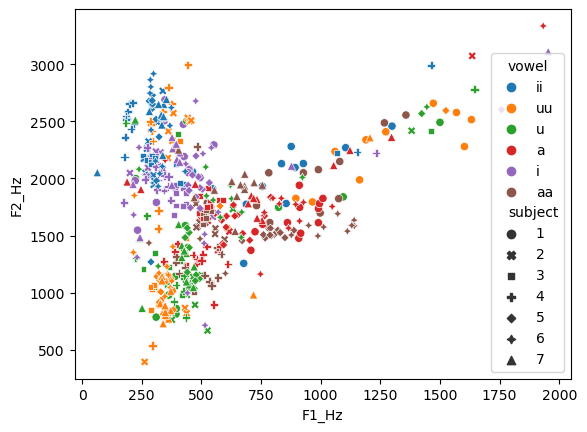

In [5]:
sns.scatterplot(data = arabic_vowels, x = 'F1_Hz', y = 'F2_Hz', hue = 'vowel', style = 'subject')

## Plot with Mahalanobis ellipse

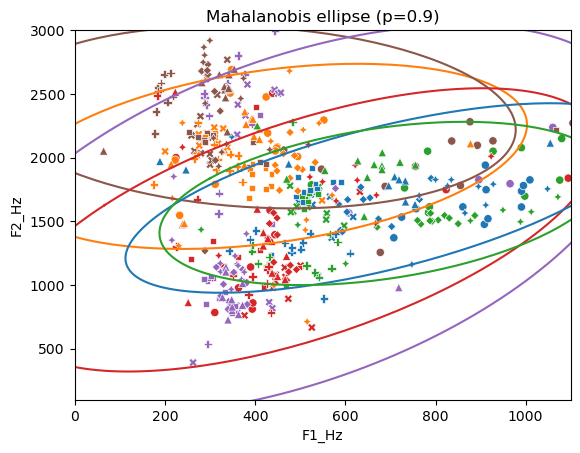

In [6]:
p = 0.90

custom_palette = {'a': 'tab:blue', 'aa': 'tab:green', 'i': 'tab:orange', 'ii': 'tab:brown', 'u': 'tab:red', 'uu': 'tab:purple'}
sns.scatterplot(data = arabic_vowels, x = 'F1_Hz', y = 'F2_Hz', hue = 'vowel', style = 'subject', palette=custom_palette)

plot_scatter_with_mahalanobis_ellipse(arabic_vowels, p, 'i', custom_palette['i'])
plot_scatter_with_mahalanobis_ellipse(arabic_vowels, p, 'ii', custom_palette['ii'])
plot_scatter_with_mahalanobis_ellipse(arabic_vowels, p, 'u', custom_palette['u'])
plot_scatter_with_mahalanobis_ellipse(arabic_vowels, p, 'uu', custom_palette['uu'])
plot_scatter_with_mahalanobis_ellipse(arabic_vowels, p, 'a', custom_palette['a'])
plot_scatter_with_mahalanobis_ellipse(arabic_vowels, p, 'aa', custom_palette['aa'])

plt.gca().invert_xaxis(); plt.gca().invert_yaxis()
plt.title(f"Mahalanobis ellipse (p={p})")
plt.xlim(0, 1100)
plt.ylim(100, 3000)
plt.gca().get_legend().remove() 
plt.show()

In [7]:
# Normalize (Lobanov or Bark) before outlier detection.
# Compute native vowel distributions separately for each vowel.
# Trim natives using Mahalanobis (97.5%).
# Freeze those distributions.
# Apply the same criteria to L2 tokens (important for fairness).
# Report % removed (should usually be <5–8%).

## Identify best exemplars

Lobanov normalization isolates vowel quality, which is what learners should acquire.

Selecting tokens closest to the native distribution center yields canonical exemplars.

Using multiple speakers’ best tokens avoids overfitting to one voice and improves generalization.

In [8]:
def add_distance_to_mean(df, native_means):
    df = arabic_vowels.copy()
    df['dist_mean'] = np.nan
    for v, mu in native_means.iterrows():
        idx = df['vowel'] == v
        d = df.loc[idx, ['F1_z','F2_z']].to_numpy() - mu[['F1_z','F2_z']].to_numpy()
        df.loc[idx, 'dist_mean'] = np.sqrt((d**2).sum(axis=1))
    return df

def add_maha2(df, group_col='vowel', xcols=('F1_z','F2_z'), ridge=1e-6):
    """
    Adds squared Mahalanobis distance 'maha2' to df, computed per group_col
    using the reference subset (e.g., native speakers) to estimate mean/cov.
    """
    out = df.copy()
    out['maha2'] = np.nan

    for gval, gref in out.groupby(group_col):
        X = gref.loc[:, xcols].to_numpy(float)
        X = X[np.isfinite(X).all(axis=1)]
        if X.shape[0] < 5:
            continue

        mu = X.mean(axis=0)
        S = np.cov(X.T) + ridge*np.eye(len(xcols))
        Sinv = np.linalg.inv(S)

        gidx = out.index[out[group_col] == gval]
        Y = out.loc[gidx, xcols].to_numpy(float)
        ok = np.isfinite(Y).all(axis=1)

        d = Y[ok] - mu
        maha2 = np.einsum('ij,jk,ik->i', d, Sinv, d)

        out.loc[gidx[ok], 'maha2'] = maha2

    return out

def mask_outliers(row, sd = 1):
    mu1 = stats.loc[row['vowel'], ('F1_z','mean')]
    sd1 = stats.loc[row['vowel'], ('F1_z','std')]
    mu2 = stats.loc[row['vowel'], ('F2_z','mean')]
    sd2 = stats.loc[row['vowel'], ('F2_z','std')]
    return (abs(row['F1_z'] - mu1) <= sd*sd1) and (abs(row['F2_z'] - mu2) <= sd*sd2)

# # Compute distance from each token to native mean
# df2 = add_distance_to_mean(arabic_vowels, native_means)

# # Remove outliers
# stats = best.groupby('vowel')[['F1_z','F2_z']].agg(['mean','std'])
# best_clean = best[best.apply(mask_outliers, axis=1)].copy()

In [9]:
# Lobanov normalization
arabic_vowels['F1_z'] = arabic_vowels.groupby('subject')['F1_Hz'].transform(
    lambda x: (x - x.mean()) / x.std(ddof=0)
)
arabic_vowels['F2_z'] = arabic_vowels.groupby('subject')['F2_Hz'].transform(
    lambda x: (x - x.mean()) / x.std(ddof=0)
)

# Compute native mean
# native_means = arabic_vowels.groupby('vowel')[['F1_z','F2_z']].mean()

# Add Mahalanobis distance
arabic_vowels = add_maha2(arabic_vowels)

# Pick very central exemplars by mahalanobis distance
CHI2_80 = 3.22
arabic_vowels = arabic_vowels[arabic_vowels['maha2'] <= CHI2_80].copy()

# best_clean
best = (
    arabic_vowels.sort_values('maha2') # or distance?
       .groupby(['subject', 'vowel'])
       .head(5)
)

/var/folders/bk/d0152l256wj91ds4hp514cj40000gn/T/ipykernel_3111/2137391375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arabic_vowels['F1_z'] = arabic_vowels.groupby('subject')['F1_Hz'].transform(
/var/folders/bk/d0152l256wj91ds4hp514cj40000gn/T/ipykernel_3111/2137391375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arabic_vowels['F2_z'] = arabic_vowels.groupby('subject')['F2_Hz'].transform(


In [10]:
# Pick best exemplar subjects
# sns.scatterplot(data = best, x = 'F1_Hz', y = 'F2_Hz', hue = 'vowel', style = 'subject')
DROPS = [1, 3, 4]
best_clean = best[~best.subject.isin(DROPS)]

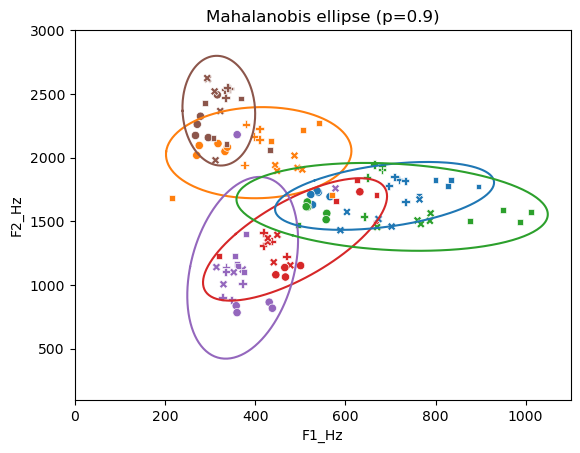

In [11]:
p = 0.90

custom_palette = {'a': 'tab:blue', 'aa': 'tab:green', 'i': 'tab:orange', 'ii': 'tab:brown', 'u': 'tab:red', 'uu': 'tab:purple'}
sns.scatterplot(data = best_clean, x = 'F1_Hz', y = 'F2_Hz', hue = 'vowel', style = 'subject', palette=custom_palette)

plot_scatter_with_mahalanobis_ellipse(best_clean, p, 'i', custom_palette['i'])
plot_scatter_with_mahalanobis_ellipse(best_clean, p, 'ii', custom_palette['ii'])
plot_scatter_with_mahalanobis_ellipse(best_clean, p, 'u', custom_palette['u'])
plot_scatter_with_mahalanobis_ellipse(best_clean, p, 'uu', custom_palette['uu'])
plot_scatter_with_mahalanobis_ellipse(best_clean, p, 'a', custom_palette['a'])
plot_scatter_with_mahalanobis_ellipse(best_clean, p, 'aa', custom_palette['aa'])

plt.gca().invert_xaxis(); plt.gca().invert_yaxis()
plt.title(f"Mahalanobis ellipse (p={p})")
plt.xlim(0, 1100)
plt.ylim(100, 3000)
plt.gca().get_legend().remove() 
plt.show()

In [12]:
# Save file paths for best exemplars to text document to move the files
best_clean.path.to_csv('best-exemplar-paths.txt', index = False, header = False)